# Visualizing the Elllipticity-Ellipticity Correlation Function

#### Spencer Everett, SLAC 7/22/2015

It is difficult to have an intuitive understanding of the ellipticity-ellipticity correlation function. Here we demonstrate how different galaxy alignments lead to different values of each component of the $\varepsilon-\varepsilon$ correlation function.

In [5]:
%load_ext autoreload
%autoreload 2

In [201]:
import numpy as np
import scipy as sp
import os,sys
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import cmath
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [7]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

In [8]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [9]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

In [10]:
B = pangloss.BackgroundCatalog(N=100,sigma_e=0.01,domain=[1.55,1.52,-1.61,-1.59]) # High ellipticity used to highlight the intrinsic shape of background sources

First let's plot some pre-lensed background galaxies represented as blue ellipticity sticks in a region containing a potential weak lens.

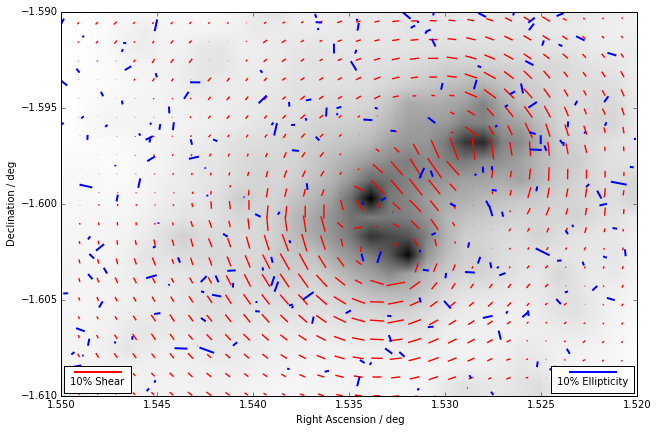

In [215]:
K.plot(subplot=[1.55,1.52,-1.61,-1.59])
S.plot()
B.plot(graph='stick')

As the background sources are generated with uniformly distributed orientation angles, we would expect there to be no correlation between the galaxy orientations at any separation distance. One way to quantify this is with a correlation function.

(Add section with corr function definition and reference the derivation document in `pangloss/docs`)

To get a better sense of what is happening inside the correlation function, we can plot the value of each component as a function of the initial angle of the first galaxy and of the difference in angle between the two.

(Add more!!)

The folowing correlation component notation is used:

$\xi_+=$ `xi_p`

$\xi_-=$ `xi_m`

$\xi_\times=$ `xi_x`

$\xi^\prime_\times=$ `xi_xp`

(Add more!!!)

Calculating each component for $\theta_i,\Delta\theta\in(0^\circ,180^\circ)$:

In [17]:
xi_p,xi_m,xi_x,xi_xp = pangloss.plotting.calc_corr_demo()

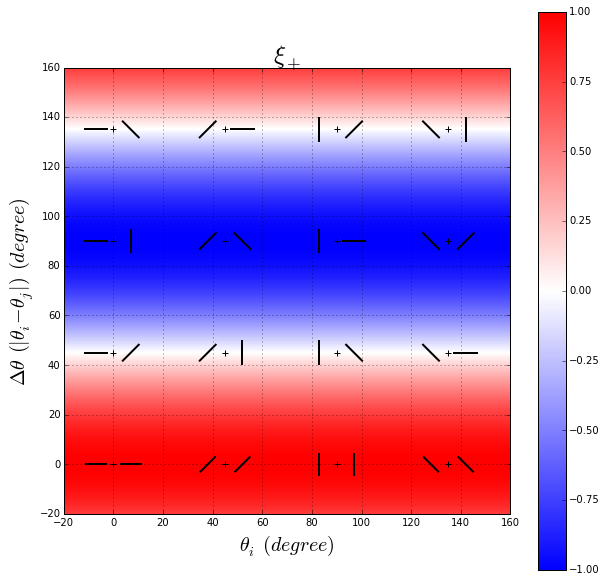

In [26]:
pangloss.plotting.plot_corr_demo(xi_p,corr_type='plus')

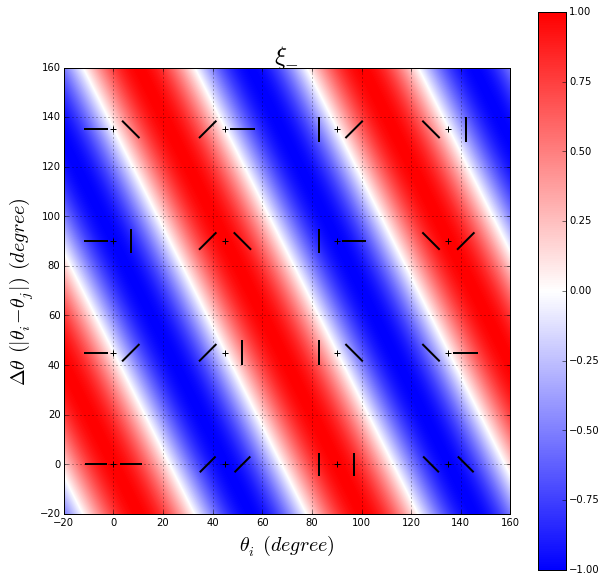

In [27]:
pangloss.plotting.plot_corr_demo(xi_m,corr_type='minus')

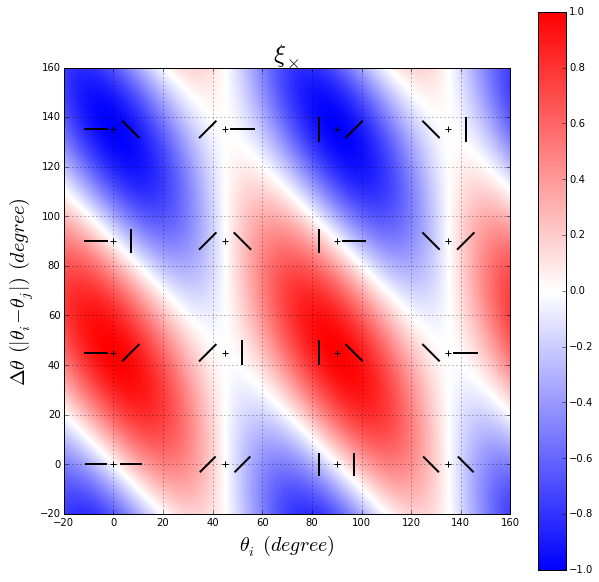

In [28]:
pangloss.plotting.plot_corr_demo(xi_x,corr_type='cross')

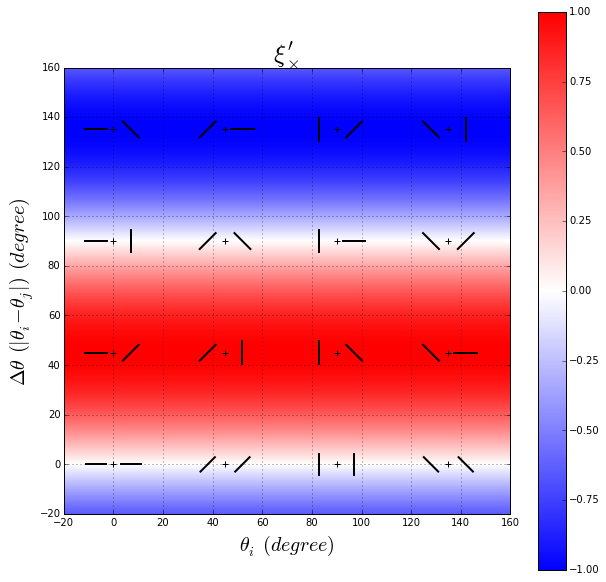

In [29]:
pangloss.plotting.plot_corr_demo(xi_xp,corr_type='crossp')

## Scratch Pad

In [291]:
def plot_lensed_colors(B,subplot=[1.1175,1.0925,-1.54,-1.5175],center=[1.10425,-1.52875],fig_size=10):
    '''
    Plot the background galaxies in the catalog B contained in the inputted subplot in different colors
    as a function of their distance from the inputted center.
    '''
    
    # Create new figure with correct axes
    fig = plt.gcf()
    pangloss.plotting.make_axes(fig,subplot=[1.1175,1.0925,-1.54,-1.5175])
    ax = plt.gca()
    
    # Extract data from galaxies contained in subplot 
    galaxies = B.return_galaxies(ra_lim=[subplot[0],subplot[1]],dec_lim=[subplot[2],subplot[3]])
    ra = np.rad2deg(galaxies['RA'])
    dec = np.rad2deg(galaxies['Dec'])
    mod = galaxies['eMod']
    phi = galaxies['ePhi']

    # Set center of lens by hand
    ra_c = center[0]
    dec_c = center[1]

    # Distance bin cutoffs
    c1 = 0.0025
    c2 = 0.005
    c3 = 0.0075
    c4 = 0.01
    c5 = 0.0125

    for i in range(np.size(ra)):
        # Calculate galaxy distance to center
        dra_c = abs(ra[i]-ra_c)
        ddec_c = abs(dec[i]-dec_c)
        r_c = np.sqrt(dra_c**2+ddec_c**2)

        # Set galaxy color based upon distance to center
        if (r_c < c1):  color = 'red'
        elif (r_c >= c1) and (r_c < c2): color = 'orange'
        elif (r_c >= c2) and (r_c < c3): color = 'yellow'
        elif (r_c >= c3) and (r_c < c4): color = 'green'
        elif (r_c >= c4) and (r_c < c5): color = 'blue'
        else: color = 'purple'

        # Plot galaxy ellipticity
        #plt.subplot(1,5,1)
        pangloss.plot_sticks(ra[i],dec[i],mod[i],-phi[i],ax,color=color)
        
    # Plot lens center
    #plt.subplot(1,5,1)
    plt.scatter(1.10425,-1.52875,s=200)
    
    # Set figure size
    fig.set_size_inches(fig_size,fig_size)
    
    # Add scale bar
    Lx, Ly = abs(subplot[0]-subplot[1]), abs(subplot[2]-subplot[3])
    L = np.mean([Lx,Ly])
    bar = AnchoredSizeBar(ax.transData,L/10.0,'10% Ellipticity',pad=0.5,loc=3,sep=5,borderpad=0.25,frameon=True)
    bar.size_bar._children[0]._linewidth = 2
    #bar.size_bar._children[0]._edgecolor = (1,0,0,1)
    ax.add_artist(bar)
        
    plt.show()
    
    return

In [298]:
def calc_corr_components(points):
    '''
    Calculate the plus, minus, cross, and cross^prime components of the correlation between each galaxy pair.
    '''
    
    del_xi_p = []
    del_xi_m = []
    del_xi_x = []
    del_xi_xp = []

    r = []
    c = []
    
    t1 = []
    t2 = []

    # Center of lens
    ra_c = 1.10425
    dec_c = -1.52875
    
    # Distance bin cutoffs
    c1 = 0.0025
    c2 = 0.005
    c3 = 0.0075
    c4 = 0.01
    c5 = 0.0125

    for point1 in points:
        for point2 in points:
            if point1 == point2:
                # Don't calculate correlation for a point with itself
                continue
            else:
                # Extract galaxy locations and ellipticities
                ra1 = point1[0]
                ra2 = point2[0]
                dec1 = point1[1]
                dec2 = point2[1]
                el1 = point1[2]
                el2 = point2[2]
                
                t1.append(el1)
                t2.append(el2)

                # Calculate separation distance and angle
                dra = ra2-ra1
                ddec = dec2-dec1
                r.append(np.sqrt(dra**2+ddec**2))
                phi = np.arctan2(ddec,dra)

                # Calculate separation distance of each object to center of lens
                dra1_c = abs(ra1-ra_c)
                dra2_c = abs(ra2-ra_c)
                ddec1_c = abs(dec1-dec_c)
                ddec2_c = abs(dec2-dec_c)

                r1_c = np.sqrt(dra1_c**2+ddec1_c**2)
                r2_c = np.sqrt(dra2_c**2+ddec2_c**2)

                # Determine color of correlation scatter point based upon distance from lens
                if (r1_c < c1) and (r2_c < c1): c.append((1,0,0,1))
                elif (r1_c >= c1) and (r1_c < c2) and (r2_c >= c1) and (r2_c < c2): c.append((1,0.5,0,0.8))
                elif (r1_c >= c2) and (r1_c < c3) and (r2_c >= c2) and (r2_c < c3): c.append((1,1,0,0.6))
                elif (r1_c >= c3) and (r1_c < c4) and (r2_c >= c3) and (r2_c < c4): c.append((0,1,0,0.4))
                elif (r1_c >= c4) and (r1_c < c5) and (r2_c >= c4) and (r2_c < c5): c.append((0,0,1,0.2))
                else: c.append((0.5,0,0.5,0.01))           

                # Calculate shear components
                g1t = -(el1*np.e**(-2j*phi)).real
                g1x = -(el1*np.e**(-2j*phi)).imag

                g2t = -(el2*np.e**(-2j*phi)).real
                g2x = -(el2*np.e**(-2j*phi)).imag

                # Calculate correlation components
                del_tt = g1t*g2t
                del_xx = g1x*g2x
                del_tx = g1t*g2x
                del_xt = g1x*g2t

                # Calculate correlation
                del_xi_p.append(del_tt+del_xx)
                del_xi_m.append(del_tt-del_xx)
                del_xi_x.append(del_tx)
                del_xi_xp.append(del_xt)
                
    print max(t1)
    print max(t2)
                
    return r,del_xi_p,del_xi_m,del_xi_x,del_xi_xp,c
            

In [305]:
def plot_corr_component(r,corr,corr_type,c):
    '''
    Plot a single correlation component.
    '''
    
    # Create another subplot
    #plt.subplot(1,5,i)
    
    plt.scatter(np.array(r)*60.0,corr,color=c)
    plt.plot([min(60.0*np.array(r)),max(60.0*np.array(r))],[0,0],'--k')
    plt.gcf().set_size_inches(10,10)
    plt.xlim([0.1,1.0])
    #plt.ylim([-1,1])
    plt.xscale('log')

    plt.xlabel(r'$\Delta\theta$ (arcmin)',fontsize=20)
    
    if corr_type == 'plus':
        plt.ylabel(r'$\delta\xi_+(\theta)$',fontsize=20)
    elif corr_type == 'minus':
        plt.ylabel(r'$\delta\xi_-(\theta)$',fontsize=20)
    elif corr_type == 'cross':
        plt.ylabel(r'$\delta\xi_\times(\theta)$',fontsize=20)
    elif corr_type == 'cross_prime':
        plt.ylabel(r'$\delta\xi_\times^\prime(\theta)$',fontsize=20)    
        
    plt.show()
    
    return
    

In [300]:
def plot_corr_color_demo(N=200):
    
    # Create a background catalog and lens the galaxies
    B = pangloss.BackgroundCatalog(N=N,sigma_e=0.01,domain=[1.1175,1.0925,-1.54,-1.515]) # High ellipticity used to highlight the intrinsic shape of background sources
    B.lens_by_map(K,S)
    
    # Plot background catalog with color scheme based upon galaxy distance from lens
    plot_lensed_colors(B)

    # Extract galaxy data
    ra = np.rad2deg(B.galaxies['RA'])
    dec = np.rad2deg(B.galaxies['Dec'])
    e1 = B.galaxies['e1']
    e2 = B.galaxies['e2']
    el = e1+1.0j*e2
    
    print max(abs(el))

    #
    points = []
    # Create set of galaxy points and ellipticities
    for i in range(len(ra)):
        r = ra[i]
        d = dec[i]
        e = el[i]
        points.append((r,d,e))

    # Calculate the correlation components between galaxies
    r,del_xi_p,del_xi_m,del_xi_x,del_xi_xp,c = calc_corr_components(points)
    
    # Calculate the shear-shear correlation function
    #gg=B.calculate_corr()
    
    # 
    plot_corr_component(r,del_xi_p,'plus',c)  
    plot_corr_component(r,del_xi_m,'minus',c)
    plot_corr_component(r,del_xi_x,'cross',c)  
    plot_corr_component(r,del_xi_p,'cross_prime',c)  
    
    # Set figure size for figure containing all subplots
    #plt.gcf().set_size_inches(50,10)
   
    return
    

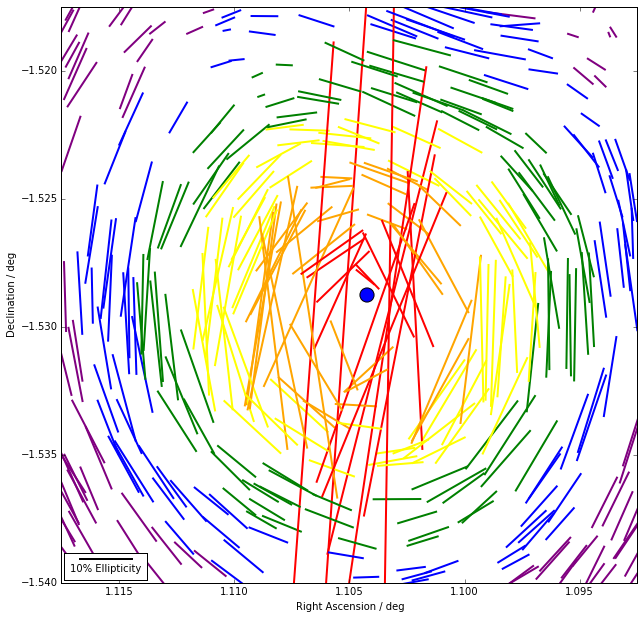

1.41325655106
(0.128952203867-0.0517619792665j)
(0.128952203867-0.0517619792665j)


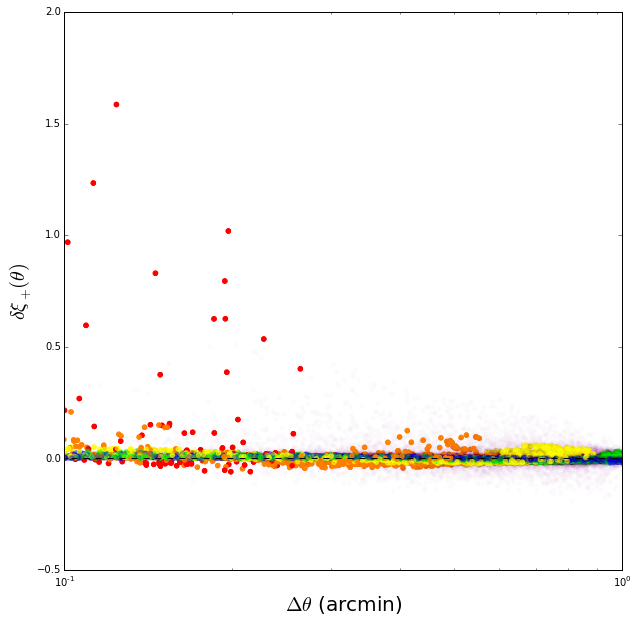

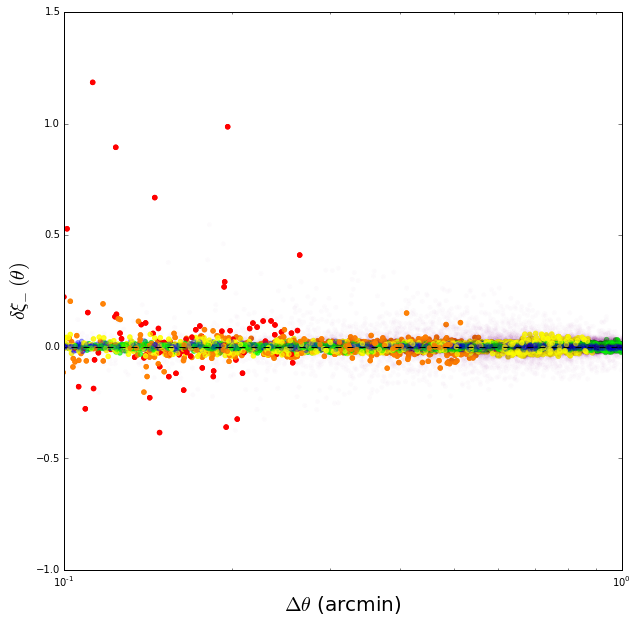

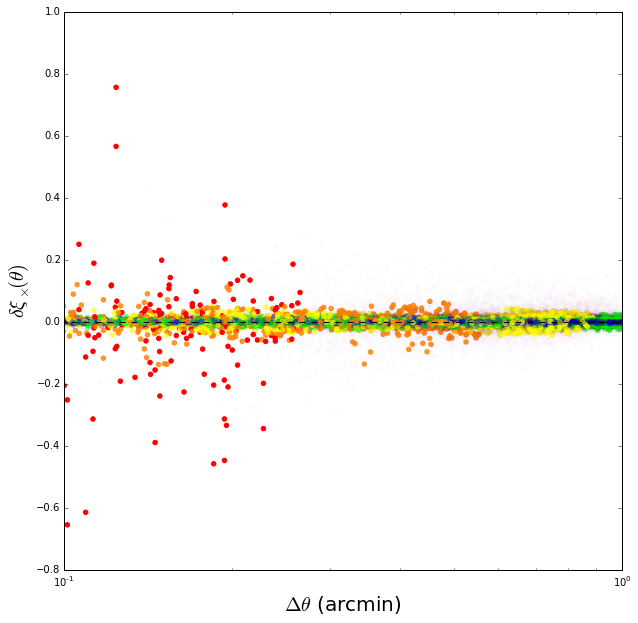

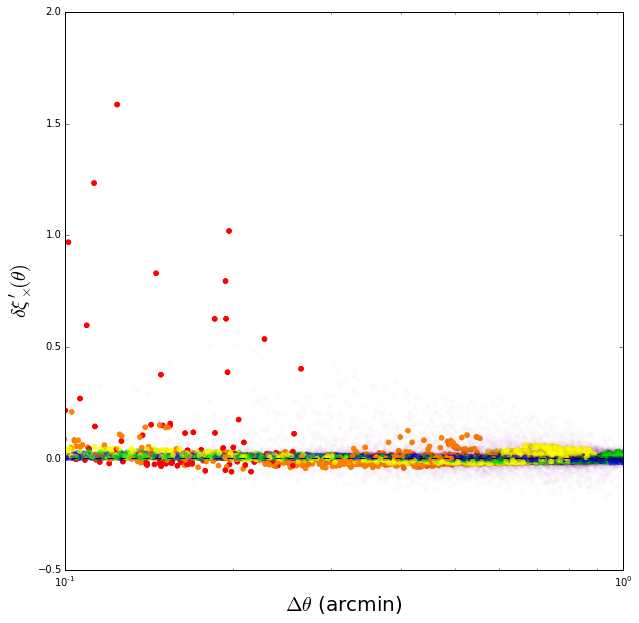

In [304]:
plot_corr_color_demo(N=200)

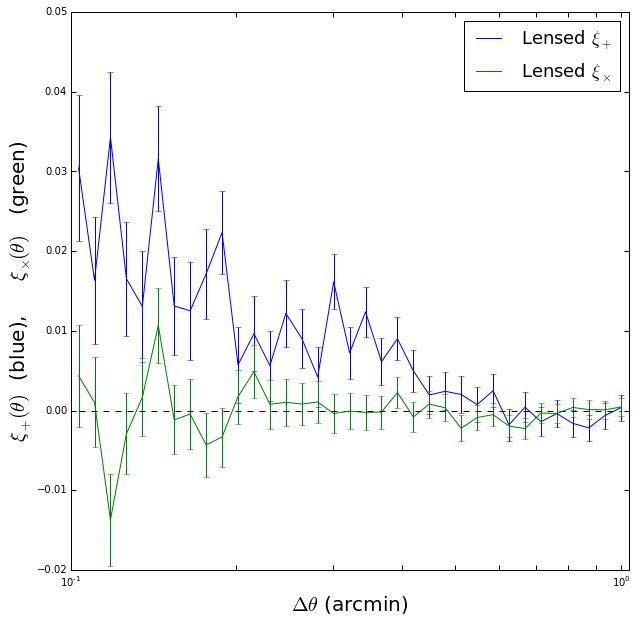

In [297]:
# Create a background catalog and lens the galaxies
B = pangloss.BackgroundCatalog(N=200,sigma_e=0.01,domain=[1.1175,1.0925,-1.54,-1.515]) # High ellipticity used to highlight the intrinsic shape of background sources
B.lens_by_map(K,S)

gg=B.calculate_corr(min_sep=0.1,max_sep=1.0)
pangloss.plot_corr(gg)

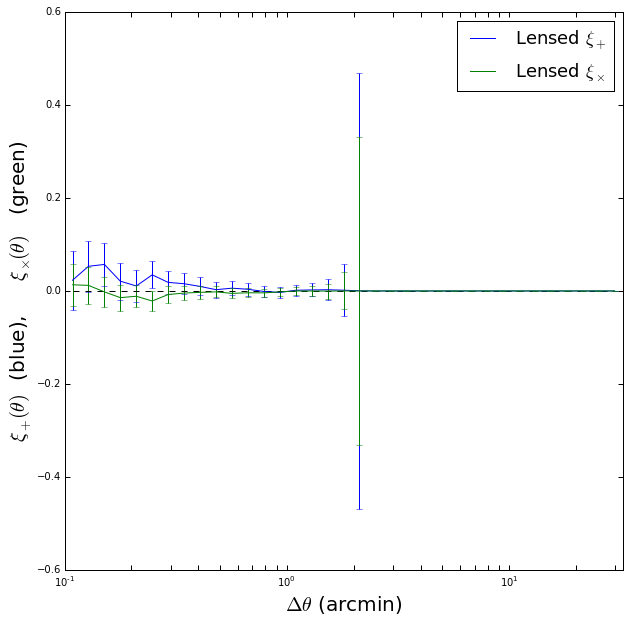

In [94]:
gg=B.calculate_corr()
pangloss.plot_corr(gg)

202050
red:  0
green:  0
yellow:  0
orange:  0
purple:  0
blue:  0


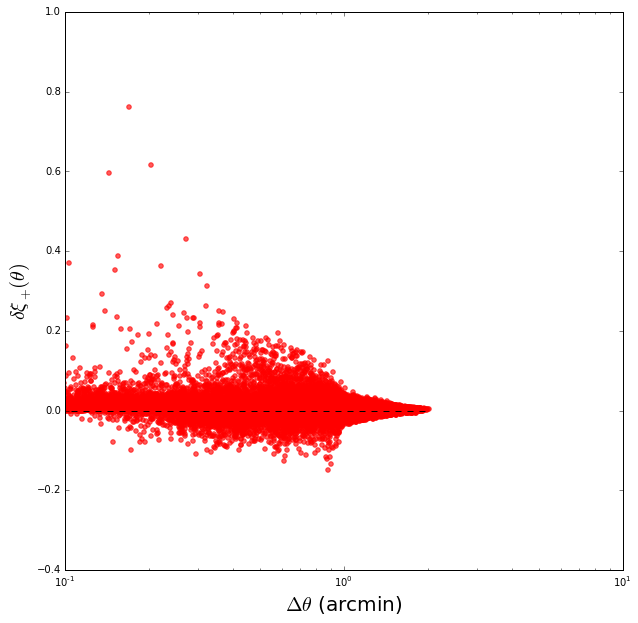

In [95]:
plt.scatter(np.array(r)*60.0,xi_p,color=c,alpha=0.4)
plt.plot([min(60.0*np.array(r)),max(60.0*np.array(r))],[0,0],'--k')
plt.gcf().set_size_inches(10,10)
plt.xlim([0.1,10])
#plt.ylim([-.01,.02])
plt.xscale('log')

plt.xlabel(r'$\Delta\theta$ (arcmin)',fontsize=20)
plt.ylabel(r'$\delta\xi_+(\theta)$',fontsize=20)

#plt.ylim([])
print np.size(r)
print 'red: ',len([val for val in c if val == 'red'])
print 'green: ',len([val for val in c if val == 'green'])
print 'yellow: ',len([val for val in c if val == 'yellow'])
print 'orange: ',len([val for val in c if val == 'orange'])
print 'purple: ',len([val for val in c if val == 'purple'])
print 'blue: ',len([val for val in c if val == 'blue'])

202050


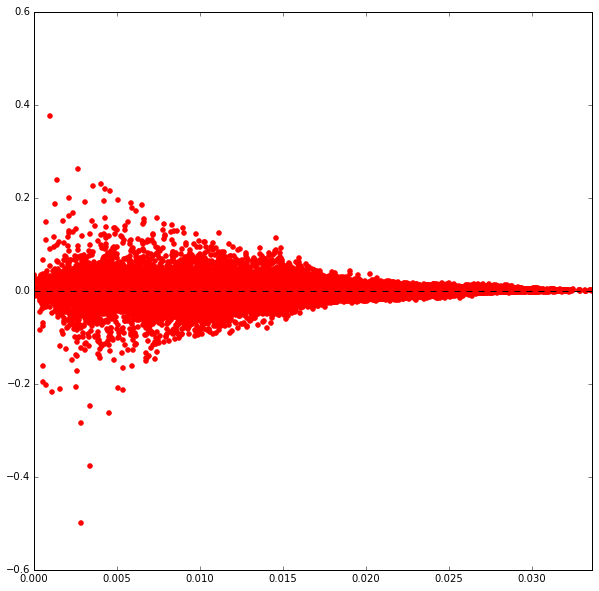

In [96]:
plt.scatter(r,xi_x,color=c)
plt.plot([min(r),max(r)],[0,0],'--k')
plt.gcf().set_size_inches(10,10)
plt.xlim([min(r),max(r)])
#plt.ylim([])
print np.size(r)